# Preterm Birth Prediction Jupyter Note By Rejoice Nyinku under the supervision of Mr. Anagu Emmanuel

## Importing necessary library required for the training

In [52]:
import shap
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, roc_auc_score

import warnings

warnings.filterwarnings('ignore')

## Importing dataset and analyzing

In [53]:
data = pd.read_excel('KUfacility_register_data_for_uploadWAISWAetalPLOSONE82020.xlsx')
data.head(5)

,id,country,facility_coded,referral_in,apgar_1,apgar_5,sex,baby_discharge_status,multiple,bba,...,record_type,mothers_age_cat,c_mother_status,c_cat_ga,c_cat_bw,c_mode_of_delivery,quarter,c_baby_status,c_birth_outcome,c_birth_weight_g2
0,162230,2,HF0004,1,7.0,9.0,Male,NaN,1.0,0,...,Birth,≤19,Discharged_Alive,28-30wks,1000-1499g,Vaginal_Delivery,Q1,Undocumented_LB,Born_Alive,1400.0
1,127964,2,HF0005,NaN,NaN,NaN,NaN,NaN,1.0,0,...,Discharge_Preg,≤19,Discharged_Alive,NaN,NaN,NaN,Q2,Undocumented_LB,Born_Alive,NaN
2,148113,2,HF0006,0,NaN,NaN,NaN,NaN,1.0,0,...,Discharge_Preg,≤19,Discharged_Alive,NaN,NaN,NaN,Q4,Undocumented_LB,Born_Alive,NaN
3,95858,1,HF014,NaN,10.0,10.0,Male,Alive,NaN,0,...,Birth,≤19,Alive,37wks+,3000-3499g,Vaginal_Delivery,Q4,Live_Baby,Born_Alive,3000.0
4,206414,1,HF007,NaN,9.0,10.0,Male,Alive,1.0,0,...,Birth,≤19,alive,37wks+,2500-2999g,Vaginal_Delivery,Q1,Live_Baby,Born_Alive,2800.0


In [54]:
data.columns

Index(['id', 'country', 'facility_coded', 'referral_in', 'apgar_1', 'apgar_5',
       'sex', 'baby_discharge_status', 'multiple', 'bba', 'doc_abortion',
       'doc_iufd', 'record_type', 'mothers_age_cat', 'c_mother_status',
       'c_cat_ga', 'c_cat_bw', 'c_mode_of_delivery', 'quarter',
       'c_baby_status', 'c_birth_outcome', 'c_birth_weight_g2'],
      dtype='object')

In [55]:
data.isna().sum()

,0
id,0
country,0
facility_coded,0
referral_in,24382
apgar_1,14603
apgar_5,20319
sex,13661
baby_discharge_status,15810
multiple,1546
bba,0


In [56]:
drop_cols = ['doc_iufd', 'id', 'facility_coded', 'referral_in', 'quarter', 'c_birth_weight_g2', 'country', 'sex']

In [57]:
data = data.drop(drop_cols, axis=1)

In [58]:
for i in data.columns:
  print(f"\nColumn: {i}")
  print(data[i].unique())


Column: apgar_1
[ 7. nan 10.  9.  6.  8.  4.  0.  5.  2.  3.  1.]

Column: apgar_5
[ 9. nan 10.  8.  4.  0.  7.  6.  5.  1.  3.  2.]

Column: baby_discharge_status
[nan 'Alive' 'Live_Baby' 'Blank' 'Dead' 'Immediate_Neonatal_Death'
 'Fresh_Still_Birth' 'Macerated_Still_Birth' 'Baby_Born_with_Defect']

Column: multiple
[ 1. nan  2.  3.]

Column: bba
[0 1]

Column: doc_abortion
[0 1]

Column: record_type
['Birth' 'Discharge_Preg' 'Abortion' 'BBA']

Column: mothers_age_cat
['≤19' '20-24' '25-29' '30-34' '≥35' 'missing']

Column: c_mother_status
['Discharged_Alive' 'Alive' 'alive' 'Undocumented' nan
 'Transferred_to_Another_Facility' 'blank'
 'Ran_away_or_Left_Before_Being_Discharged' 'dead' 'Died'
 'Ran_Away_with_Fistula' 'Dead']

Column: c_cat_ga
['28-30wks' nan '37wks+' '34-36wks' '<24wks' '31-33wks' '24-27wks']

Column: c_cat_bw
['1000-1499g' nan '3000-3499g' '2500-2999g' '3500g+' '2000-2499g'
 '1500-1999g' '<500g' '500-999g']

Column: c_mode_of_delivery
['Vaginal_Delivery' nan 'Caesar

In [59]:
# Converting the target column from multi-classification to binary classification
# making 0 = Preterm and 1 Full-term(Not Preterm)

mapping = { '28-30wks'  : 0,
            '37wks+'    : 1,
            '34-36wks'  : 0,
            '<24wks'    : 0,
            '31-33wks'  : 0,
            '24-27wks'  : 0
          }
data['c_cat_ga'] = data['c_cat_ga'].map(mapping)

In [60]:
data.isna().sum().any()

np.True_

In [61]:
data = data.dropna()

In [62]:
data.shape

(32267, 14)

In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32267 entries, 4 to 61017
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   apgar_1                32267 non-null  float64
 1   apgar_5                32267 non-null  float64
 2   baby_discharge_status  32267 non-null  object 
 3   multiple               32267 non-null  float64
 4   bba                    32267 non-null  int64  
 5   doc_abortion           32267 non-null  int64  
 6   record_type            32267 non-null  object 
 7   mothers_age_cat        32267 non-null  object 
 8   c_mother_status        32267 non-null  object 
 9   c_cat_ga               32267 non-null  float64
 10  c_cat_bw               32267 non-null  object 
 11  c_mode_of_delivery     32267 non-null  object 
 12  c_baby_status          32267 non-null  object 
 13  c_birth_outcome        32267 non-null  object 
dtypes: float64(4), int64(2), object(8)
memory usage: 3.7+ MB


## Converting categorical data to numerical data

In [64]:
encoder = LabelEncoder()

In [65]:

for col in data.select_dtypes(include='object').columns:
  data[col] = encoder.fit_transform(data[col])


In [66]:
print(encoder.classes_)

['Born_Alive' 'Still_Birth']


## Visualizing the data

In [67]:
data.describe()

,apgar_1,apgar_5,baby_discharge_status,multiple,bba,doc_abortion,record_type,mothers_age_cat,c_mother_status,c_cat_ga,c_cat_bw,c_mode_of_delivery,c_baby_status,c_birth_outcome
count,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000,32267.000000
mean,8.120247,9.172901,3.492949,1.036663,0.001952,0.000744,1.997242,1.708743,4.166331,0.868441,3.847057,2.605169,2.031580,0.018843
std,1.767593,1.681077,2.892660,0.192175,0.044144,0.027263,0.059637,1.741124,2.472675,0.338015,1.036079,0.797509,0.412446,0.135972
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,9.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,2.000000,1.000000,3.000000,3.000000,2.000000,0.000000
50%,8.000000,10.000000,6.000000,1.000000,0.000000,0.000000,2.000000,1.000000,2.000000,1.000000,4.000000,3.000000,2.000000,0.000000
75%,9.000000,10.000000,6.000000,1.000000,0.000000,0.000000,2.000000,4.000000,7.000000,1.000000,5.000000,3.000000,2.000000,0.000000
max,10.000000,10.000000,7.000000,3.000000,1.000000,1.000000,2.000000,5.000000,9.000000,1.000000,7.000000,3.000000,5.000000,1.000000


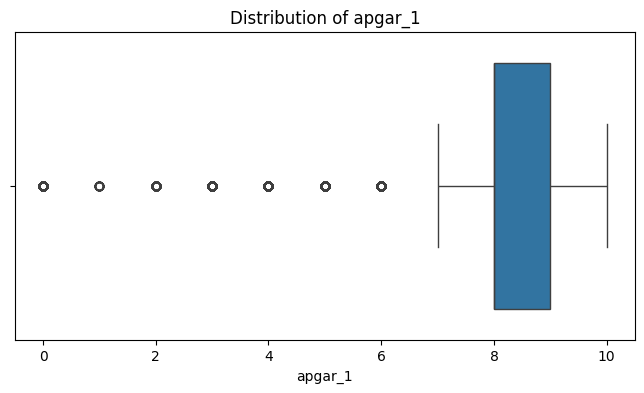

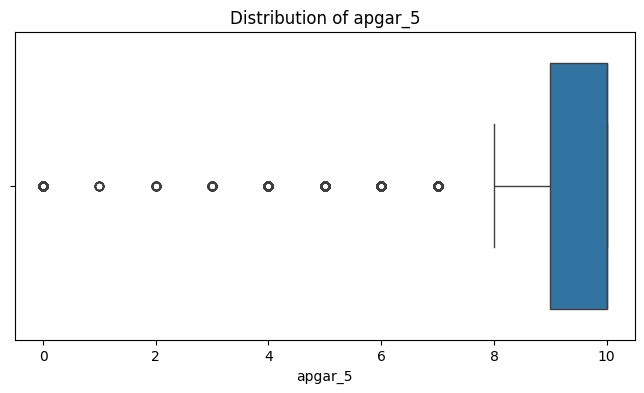

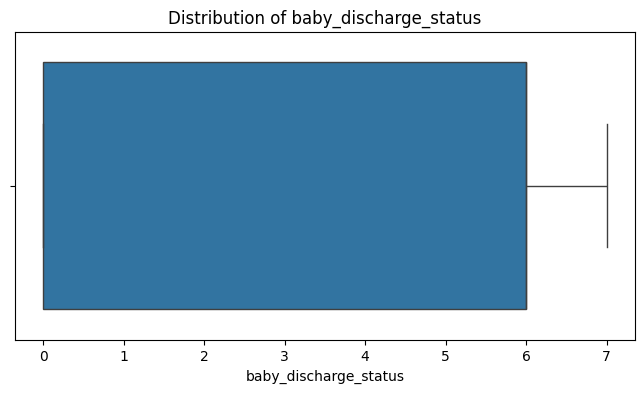

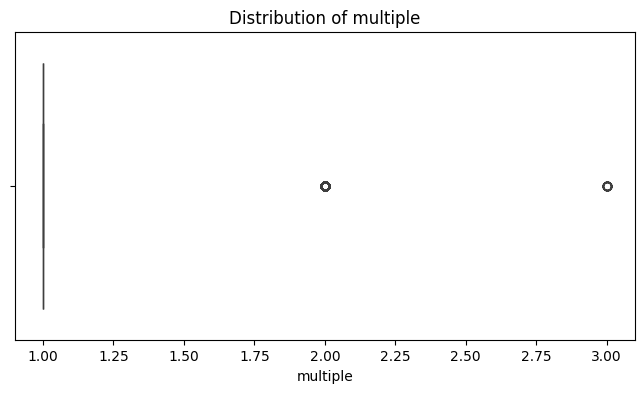

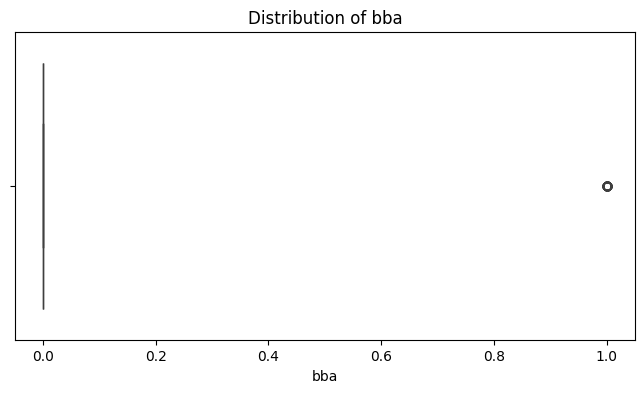

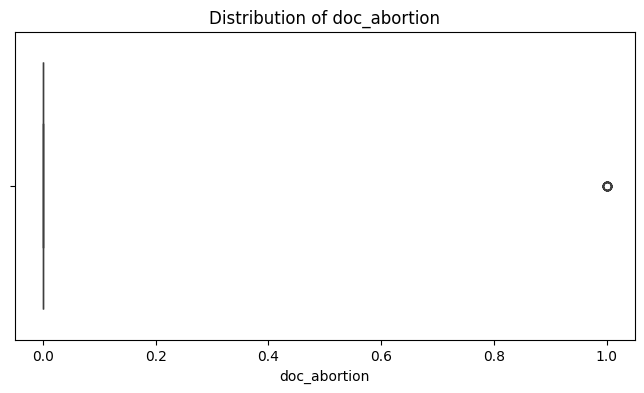

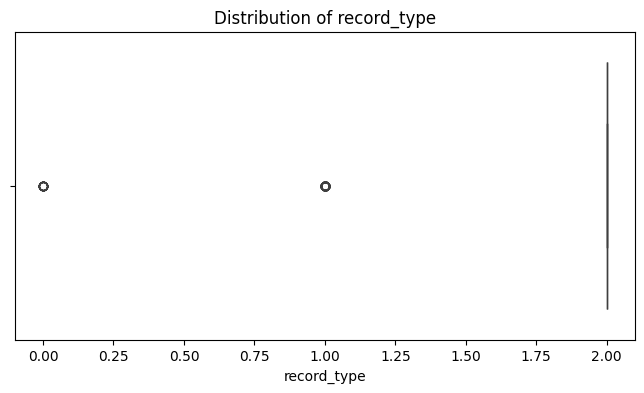

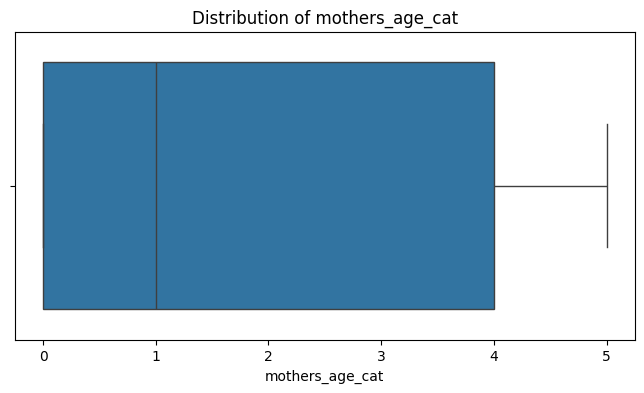

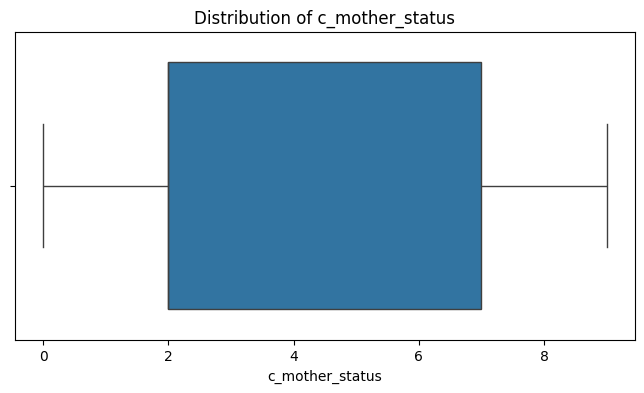

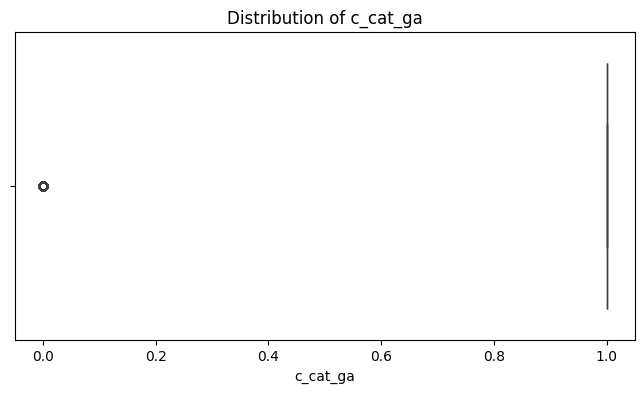

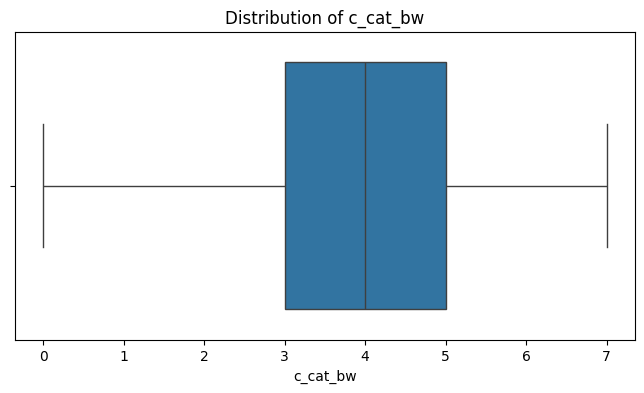

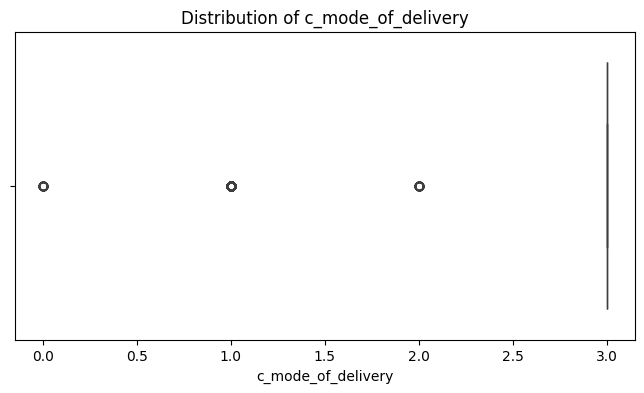

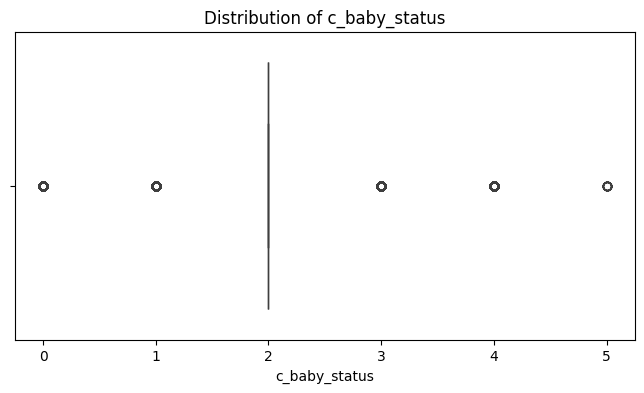

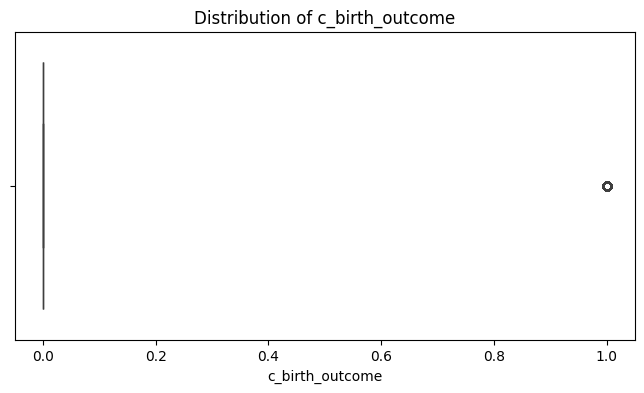

In [68]:
# Visualize feature distributions
for column in data.columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Distribution of {column}')
    plt.show()

### Solving Outliers
These outliers are clinically meaningful and therefore no need to remove them

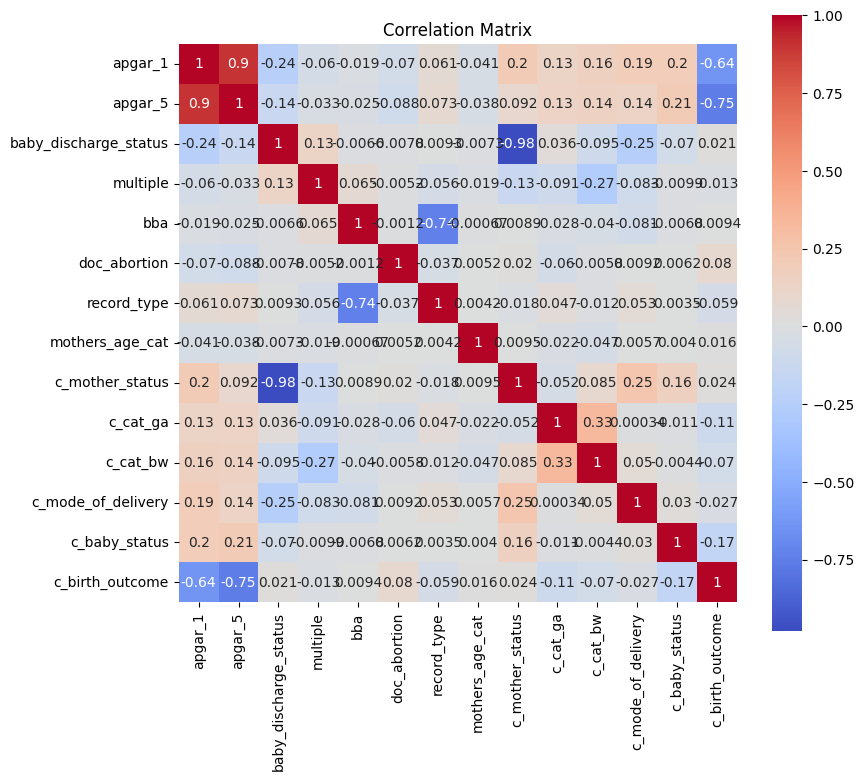

In [69]:
# Dataset Correlation
plt.figure(figsize=(9, 8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix')
plt.show()

In [70]:
#Removing depent variables poorly correlated variable with the target varible
dropping = ['baby_discharge_status', 'c_mode_of_delivery', 'c_baby_status', 'c_mother_status', 'mothers_age_cat']

data = data.drop(dropping, axis=1)

In [71]:
data.shape

(32267, 9)

In [72]:
data['c_cat_ga'].value_counts()

,count
c_cat_ga,
1.0,28022
0.0,4245


## Finaling Preprocessing.

### Seperating the Target and the features and using numpy array for faster training

In [73]:
#Converting pandas dataframe to numpy arrear
X = data.drop('c_cat_ga', axis=1)
y = data['c_cat_ga']

### Data Normalization using MinMax Scaler
To Normalize the data such that, the maximun value is 1 and the minimun value is 0

In [74]:
# Scale the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

### Balancing the dataset using Random Over Sampling
This is to randomly add up the minimum target values to be equal with the highest

In [75]:
# Apply random oversampling
ros = SMOTE(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_scaled, y)

In [76]:
#To make sure the dataset for training is balanced
print(f'Unique y Values for training: {y_resampled.unique()}')
print(f'Number of occurance of the observation: {y_resampled.value_counts()}')

Unique y Values for training: [1. 0.]
Number of occurance of the observation: c_cat_ga
1.0    28022
0.0    28022
Name: count, dtype: int64


### Feature splitting
Splitting the Training data and the Testing data. 80% - 20%

In [77]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

## Model Training with various Machine Learning Algorithm

In [78]:
# KNN Model
knn = KNeighborsClassifier()
knn_param_grid = {
    'n_neighbors': [1, 3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}
knn_grid_search = GridSearchCV(knn, knn_param_grid, scoring='roc_auc', cv=4)
knn_grid_search.fit(X_train, y_train)
print("Best KNN Parameters:", knn_grid_search.best_params_)

knn_model = knn_grid_search.best_estimator_
y_pred_knn = knn_model.predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)
acc_knn = accuracy_score(y_test, y_pred_knn)

Best KNN Parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}


In [79]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}
log_grid_search = GridSearchCV(log_reg, log_param_grid, scoring='roc_auc', cv=4)
log_grid_search.fit(X_train, y_train)
print("Best Logistic Regression Parameters:", log_grid_search.best_params_)

log_reg_model = log_grid_search.best_estimator_
y_pred_log_reg = log_reg_model.predict(X_test)
cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
acc_log_reg = accuracy_score(y_test, y_pred_log_reg)

Best Logistic Regression Parameters: {'penalty': 'l1', 'solver': 'saga'}


In [80]:
# Random Forest
rf = RandomForestClassifier()
rf_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [10, 50, 100],
    'random_state': [42]
}
rf_grid_search = GridSearchCV(rf, rf_param_grid, scoring='roc_auc', cv=4)
rf_grid_search.fit(X_train, y_train)
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

rf_model = rf_grid_search.best_estimator_
y_pred_rf = rf_model.predict(X_test)
cm_rf = confusion_matrix(y_test, y_pred_rf)
acc_rf = accuracy_score(y_test, y_pred_rf)

Best Random Forest Parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'n_estimators': 100, 'random_state': 42}


In [82]:
# Support Vector Machine
# Default params used, since GripSearchCV
# utilized 2+ hours to infere the data

svm = SVC(probability=True)

svm_model = svm.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)
acc_svm = accuracy_score(y_test, y_pred_svm)

In [83]:
# XXBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators' : [50, 100],
    'learning_rate': ['0.01', '0.1'],
    'max_depth': [2, 4, 7],
    'min_child_weight':[1, 3],
    'subsample' : [0.8, 1.0],
    'scale_pos_weight': [1, 2, 5]
}
xgb_grid_search = GridSearchCV(xgb, xgb_param_grid, scoring='roc_auc', cv=4)
xgb_grid_search.fit(X_train, y_train)
print("Best XGB Parameters:", xgb_grid_search.best_params_)

xgb_model = xgb_grid_search.best_estimator_
y_pred_xgb = xgb_model.predict(X_test)
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
acc_xgb = accuracy_score(y_test, y_pred_xgb)

Best XGB Parameters: {'learning_rate': '0.1', 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 100, 'scale_pos_weight': 1, 'subsample': 1.0}


## Models Evaluations

### Classification Report

In [84]:
# After training all models (KNN, Logistic Regression, Random Forest, and SVM)

def evaluate_model(model_name, y_true, y_pred):
    return {
        'Model': model_name,
        'Accuracy': accuracy_score(y_true, y_pred),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'F1 Score': f1_score(y_true, y_pred, average='weighted')
    }

# Calculate metrics for all models
metrics = pd.DataFrame([
    evaluate_model('KNN', y_test, y_pred_knn),
    evaluate_model('Logistic Regression', y_test, y_pred_log_reg),
    evaluate_model('Random Forest', y_test, y_pred_rf),
    evaluate_model('SVM', y_test, y_pred_svm),
    evaluate_model('XGBoost', y_test, y_pred_xgb)
])

# Format and display metrics
metrics_styled = metrics.style.format({
    col: '{:.4f}' for col in metrics.columns if col != 'Model'
}).background_gradient(cmap='YlOrRd', subset=[col for col in metrics.columns if col != 'Model'])

print("\nModel Evaluation Metrics:")
print(metrics.to_string(index=False))


Model Evaluation Metrics:
              Model  Accuracy  Precision   Recall  F1 Score
                KNN  0.680525   0.718296 0.680525  0.666091
Logistic Regression  0.670979   0.672223 0.670979  0.670386
      Random Forest  0.692033   0.701169 0.692033  0.688502
                SVM  0.669284   0.728845 0.669284  0.646280
            XGBoost  0.689803   0.692089 0.689803  0.688880


In [85]:
print(f"Random Forest Accuracy: {acc_rf:.4f}")

Random Forest Accuracy: 0.6920


### Models Accuracies

In [86]:
print("\nModel Accuracies:")
print(f"KNN Accuracy: {acc_knn:.4f}")
print(f"Logistic Regression Accuracy: {acc_log_reg:.4f}")
print(f"Random Forest Accuracy: {acc_rf:.4f}")
print(f"SVM Accuracy: {acc_svm:.4f}")
print(f"XGBoost Accuracy: {acc_xgb:.4f}")


Model Accuracies:
KNN Accuracy: 0.6805
Logistic Regression Accuracy: 0.6710
Random Forest Accuracy: 0.6920
SVM Accuracy: 0.6693
XGBoost Accuracy: 0.6898


### Models Confusion Matrix

In [87]:
# Function to plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Preterm', 'Not Preter'],
                yticklabels=['Preterm', 'Not Preterm'])
    plt.title(title)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

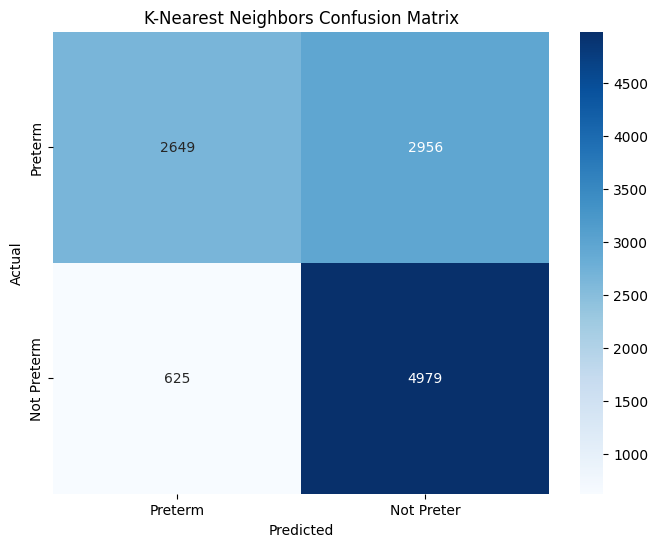

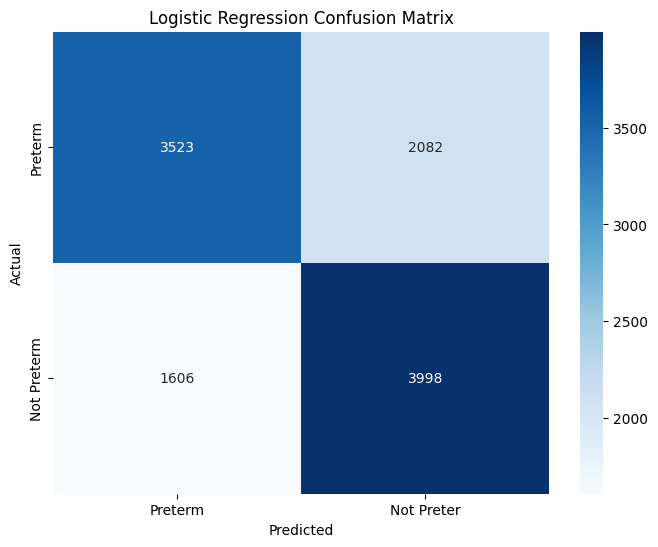

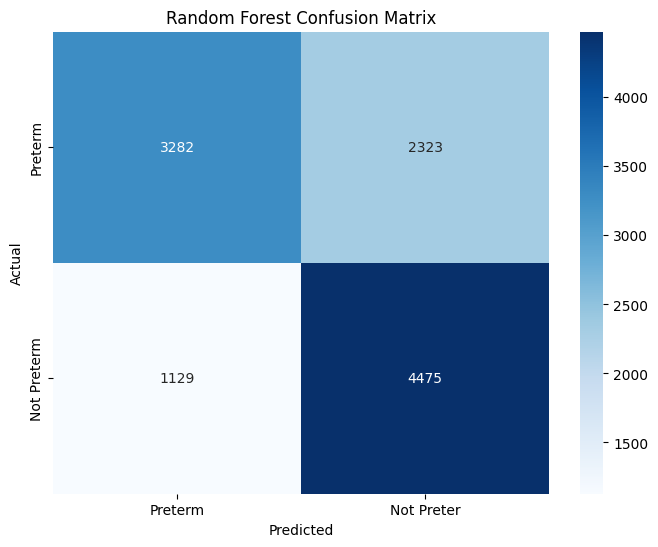

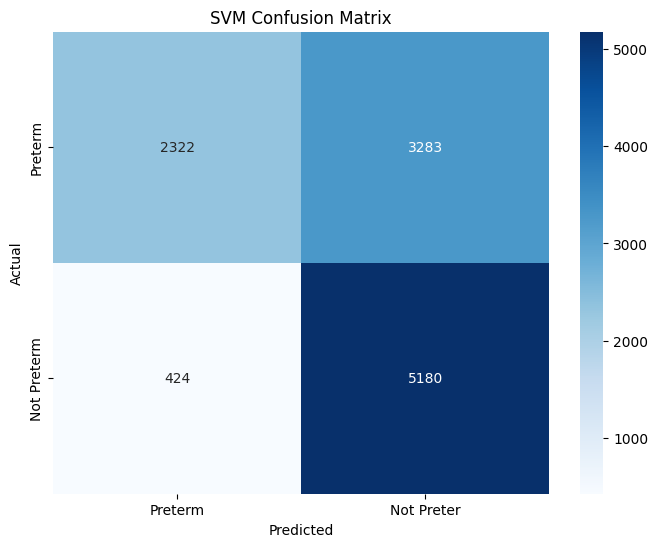

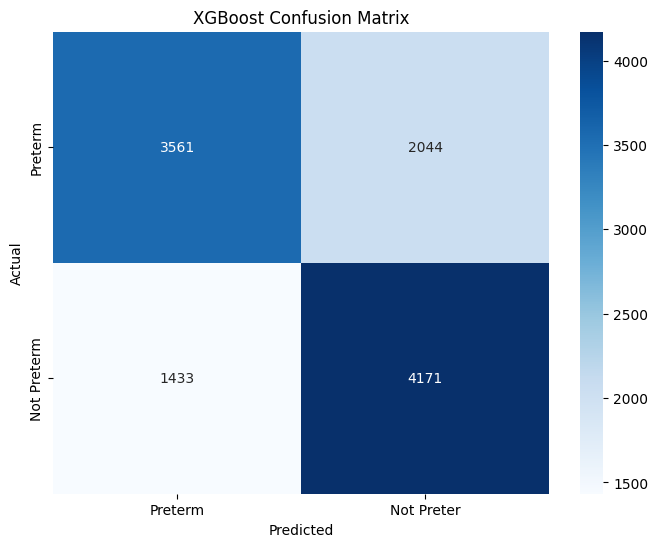

In [88]:
# Plot confusion matrices
plot_confusion_matrix(cm_knn, "K-Nearest Neighbors Confusion Matrix")
plot_confusion_matrix(cm_log_reg, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(cm_rf, "Random Forest Confusion Matrix")
plot_confusion_matrix(cm_svm, "SVM Confusion Matrix")
plot_confusion_matrix(cm_xgb, "XGBoost Confusion Matrix")

### ROC_AUC ANALYSIS

In [89]:
#DECISION FUNCTIONS


rf_score  = rf_model.predict_proba(X_test)
knn_score = knn_model.predict_proba(X_test)[:, 1]
log_reg_score = log_reg_model.predict_proba(X_test)[:, 1]
xgb_score = xgb_model.predict_proba(X_test)[:, 1]
svm_score = svm_model.predict_proba(X_test)[:, 1]

In [90]:
# Computing the ROC Curve and AUC

rf_score = rf_score[:, 1]

fpr_knn, tpr_knn, _ = roc_curve(y_test, knn_score)
roc_auc_knn = auc(fpr_knn, tpr_knn)


fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_score)
roc_auc_rf = auc(fpr_rf, tpr_rf)

fpr_log_reg, tpr_log_reg, _ = roc_curve(y_test, log_reg_score)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)


fpr_svm, tpr_svm, _ = roc_curve(y_test, svm_score)
roc_auc_svm = auc(fpr_svm, tpr_svm)

fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_score)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

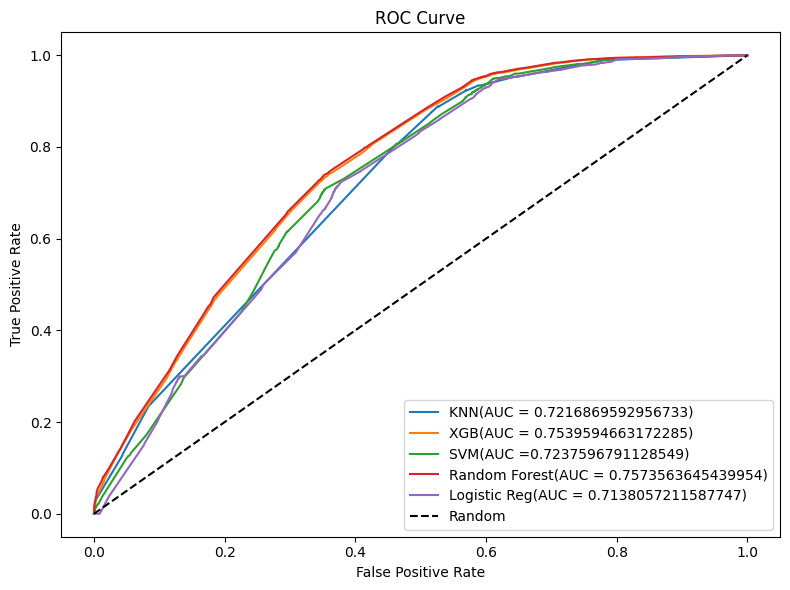

In [91]:
#Plot all ROC Curves

plt.figure(figsize=(8,6))
plt.plot(fpr_knn, tpr_knn, label=f"KNN(AUC = {roc_auc_knn})")
plt.plot(fpr_xgb, tpr_xgb, label = f"XGB(AUC = {roc_auc_xgb})")
plt.plot(fpr_svm, tpr_svm, label=f"SVM(AUC ={roc_auc_svm})")
plt.plot(fpr_rf, tpr_rf, label = f"Random Forest(AUC = {roc_auc_rf})")
plt.plot(fpr_log_reg, tpr_log_reg, label=f"Logistic Reg(AUC = {roc_auc_log_reg})")

plt.plot([0,1], [0,1], 'k--', label='Random')

plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Saving the Best Model

In [92]:
best_accuracy = max(acc_knn, acc_log_reg, acc_rf, #acc_svm, acc_xgb
                    )
if best_accuracy == acc_rf:
    best_model = rf_model
elif best_accuracy == acc_log_reg:
    best_model = log_reg_model
else:
    best_model = knn_model
# elif best_accuracy == acc_svm:
#     best_model = svm_model
# else:
#     best_model = xgb_model

print(best_accuracy)
joblib.dump(best_model, 'preterm_model.joblib')
joblib.dump(scaler, 'preterm_scaler.joblib')

0.6920331876170934


['preterm_scaler.joblib']

## Explainable AI using SHAP for the saved model (Random Forest)

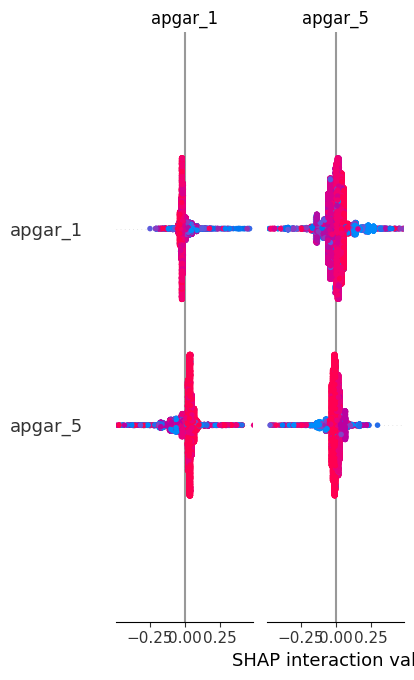

In [93]:
explainer = shap.TreeExplainer(rf_model)

shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=data.columns, plot_type='bars')

